In [2]:
%%html
<style type="text/css">
img{width:500px; height:200px}
</style>

<img style="float:left;" src="https://ts1.cn.mm.bing.net/th/id/R-C.58c93ffe86fd63d4612fa936b26ca70c?rik=3pZtzfRbPLmAeg&riu=http%3a%2f%2fstatics.phbs.pku.edu.cn%2fstatics%2fimages%2fphbs_2017%2findex_logo.png&ehk=pTpCI9AZbDr2LSA8iYICtlHbI10JzVwazjq7PlqONdU%3d&risl=&pid=ImgRaw&r=0" width=30%/>

# <center>  Snowball Option pricing under Monte Carlo simulation
##### <center> Chen Wanqing, Chen Ziying

## 1. Introduction of snowball 

When the price of the underlying asset exceeds an agreed level on a specified date, the snowball product will triggers **autocall(the porduct terminate in advanced)**

**knock out**: the price of the underlying asset on any of the knock-out observation days is **above the knock out level (eg:103%)** of the initial price  

**knock in**: the price of the underlying asset on any of the knock-in observation days is **below the knock in level (eg:80%)** of the initial price

### 1.1 A product as an example 

1. **Underlying asset**: 000905.SH


2. **Start date**: 2021/08/26


3. **End date**: 2026/08/28


4. **Observation period**: after 3 months closure period

    + Observation start date: 2021/11/26
   
    + Observation end date: 2023/08/25
    
    + Observe knock in everyday
    
    + Observe knock out every month 
  
  
5. **Maturity date**: 2023/08/23 - 2026/08/12


6. **Knock out level**: 100%


7. **Knock in level**: 75%


8. **Annual return**: 15.2%

### 1.2 return scenarios

All the scenarios are grouped into three categories:

1. knock out

2. both not knock-in and not knock-out

3. knock-in but not knock-out

#### 1.2.1 knock out

As long As the knock-out happens (no matter if the knock-in happens or not), the product will mature prior to the maturity date, and the investor will receive $(coupon + 1) \times t \times principle %$, where $t$ is the time the product knocks out.

![jupyter](https://raw.githubusercontent.com/qwq-cwq/PHBS_ASP_project/main/snowball_docs/pictures/1_knockout.png)

![jupyter](https://raw.githubusercontent.com/qwq-cwq/PHBS_ASP_project/main/snowball_docs/pictures/2_knock_and_once_knock_in.png)

#### 1.2.2 Not knock-in and not knock-out
In this case, the investor can receive all the coupon until the maturity. The payoff is the $(coupon + 1) \times principle \times T $

![jupyter](https://raw.githubusercontent.com/qwq-cwq/PHBS_ASP_project/main/snowball_docs/pictures/3_never_out_and_never_in.png)

#### 1.2.3 knock-in but not knock-out

Knock-in but not kmnock-out, at the last observation date, the price is above the initial price, the investor will not receive coupon, but will not lose the principle neither. The payoff is 0. 

![jupyter](https://raw.githubusercontent.com/qwq-cwq/PHBS_ASP_project/main/snowball_docs/pictures/4_in_not_out.png)

Knock-in but not knock-out, at the last observation date, the price is lower than the initial price, the investor has to bear the lost himself.The loss is $ {S_T}<{S_0}$. 

![jupyter](https://raw.githubusercontent.com/qwq-cwq/PHBS_ASP_project/main/snowball_docs/pictures/5_in_not_out_lower_than_initial.png)

<font size=1> *Pictures are borrowed from:  
Industrial Security.(2021) .OTC Options Series 5: How to Price a Snowball Option. https://max.book118.com/html/2021/0629/6034054242003204.shtm* </font>  

## 2. Volatility Calibration

### 2.1 BS Model
#### 2.1.1 PDE
**Underlying price following GBM**
$$ \frac{dS_{t}}{S_t} = r dt + \sigma dW_t  \tag{1}$$
**Volatility is constant in the case of BS**

#### 2.1.2 discretization
**Underlying price has a solution:**
$$ log(\frac{S_{t+\Delta_t}}{S_t}) = (r - 0.5  \sigma^2)  \Delta_t + \sigma \sqrt{\Delta_t} W_1 \tag{2}$$


### 2.2 Heston Model
#### 2.2.1 PDE
**Underlying price following GBM**
$$ \frac{dS_{t}}{S_t} = r dt + \sigma_t dW_t  \tag{3}$$
**Volatility follows Heston model**
$$ dv_t = \kappa (\theta - v_t) dt + \nu \sqrt{v_t}dZ_t  \tag{4}$$
**the correlation between $W_t$ and $Z_t$ is rho**
$$dW_t = \rho dZ_t + \rho_*dX_t, \rho_*=\sqrt{1-\rho^2} \tag{5}$$

#### 2.1.2 discretization
**Underlying price has a solution:**
$$ log(\frac{S_{t+\Delta_t}}{S_t}) = (r - 0.5  \sigma_t^2)  \Delta_t + \sigma_t \sqrt{\Delta_t} W_1 \tag{6}$$
**Euler scheme for time discretization of volatility**
$$ v_{t+\Delta_t} = v_t + \kappa (\theta - v_t) \Delta_t + \nu \sqrt{v_t \Delta_t}Z1  \tag{7} $$


**Andersen's method to solve the problem of $v_t$ below zero**  
Andersen L (2008) Simple and efficient simulation of the Heston stochastic volatility model. Journal of Computational Finance 11:1–42. https://doi.org/10.21314/JCF.2008.189


### 2.3 Calibration results

#### 2.3.1 Data
We obtained the volatility data of the CSI500ETF vanilla option from the wind. The data begins at 2022/09/19 when the option is listed. The data we use has a 1 year maturity.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pyfeng as pf

import os
cwd = '\\'.join(os.getcwd().split('\\')[:-1])
os.chdir(cwd + '\\pyfeng')
from snowball import *
os.chdir(cwd + '\\snowball_docs')

The shown in below, the data has different strikes, the columns 600/800/... means  the strike is 60%/80%/... of the spot price.
The dates start at 2022/09/19 and end at 2022/10/25

In [3]:
IV_df = pd.read_excel('IV_with_different_strike_1Y.xlsx', header=2)
strike_ls = [600,800,900,950,975,1000, 1025, 1050, 1100, 1200, 1300]
IV_df.columns = ['date'] +IV_df.columns[1:].str[10:].tolist()
IV_df = IV_df.set_index('date')
IV_df =IV_df[[str(x) for x in strike_ls]]
IV_df = IV_df.dropna(axis=0)
IV_df

,600,800,900,950,975,1000,1025,1050,1100,1200,1300
date,,,,,,,,,,,
20220919,23.88,24.15,22.76,22.51,22.36,22.25,22.40,22.14,22.20,21.96,22.80
20220920,27.80,24.71,23.16,22.75,22.45,22.15,22.02,21.95,21.81,21.96,22.20
20220921,25.41,23.76,23.06,22.73,22.58,22.42,22.27,22.13,21.85,21.33,20.87
20220922,27.70,24.89,23.49,22.93,22.53,22.18,21.99,21.83,21.61,21.80,22.55
20220923,28.70,25.48,23.87,23.16,22.77,22.43,22.26,22.16,21.85,21.85,22.04
20220926,28.09,25.61,24.37,23.70,23.33,22.92,22.64,22.48,22.23,22.25,22.68
20220927,29.45,25.61,23.69,22.99,22.67,22.37,22.12,21.90,21.64,21.67,21.88
20220928,33.63,27.71,24.89,24.18,23.73,23.44,23.23,22.99,22.77,22.72,23.09
20220929,31.73,27.01,24.69,23.87,23.61,23.39,23.17,22.92,22.69,22.78,23.04


We choose the date 2022/10/19 and fit the volatility curve. 2022/10/19 is chosen because:
- the option is listed at the date 2022/09/19 so the liquidity at the beginning of the dates would be not so good, and the vol smile might be biased.
- October has a long holiday and a before and after the holiday the market was quite volatile.
- After 2022/10/21, the market again experienced dramatic drop...
- 2022/10/19 might be suitable since the option has listed one month.

#### 2.3.2 BS model
Under BS model, the volatility is constant, we just assume sigma=0.2225.

*Note: the interest rate is 10 year Government Bond yield*

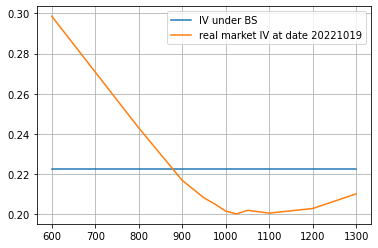

In [4]:
model_BS = pf.Bsm(sigma=0.2225, intr=0.0273, divr=0)
vol_BS = model_BS.vol_smile(np.array(strike_ls)/1000 * 5.919, 5.919, texp=1, model='bsm')

date = 20221019
plt.plot(strike_ls, vol_BS, label='IV under BS')
plt.plot(strike_ls, IV_df.loc[date,:]/100, label='real market IV at date {}'.format(date))
plt.legend()
plt.grid()
plt.show()

#### 2.3.3 Calibrate Heston Model
At date 2022/10/19, we find the parameters that fit the real market volatility smile:  sigma = 0.05, vov = 0.45, rho = -0.2, mr = 0.28, theta = 0.06, intr=0.0273. 

*Note: the interest rate is a 1 year Treasury Bond.*

- First, we explored the parameters by hand, and discovered some patterns of how these parameters change the shape of volatility smile(will be covered in Part 4), and we find the parameters that fit the market volatility is: sigma=0.05, vov=0.47, rho=-0.2, mr=0.15, theta=0.1. 

In [5]:
# the underlying asset of CSI500 ETF option is CSI500ETF(510500), we load the price of CSI500 ETF here
CSI500ETF_close = pd.read_excel('500ETF_close_price.xlsx',index_col=0)

underlying_price = CSI500ETF_close.loc['2022-10-19','close']
model_Heston = pf.HestonFft(sigma=0.05, vov=0.47, rho=-0.2, mr=0.15, theta=0.1, intr=0.0273)
vol_Heston = model_Heston.vol_smile(np.array(strike_ls)/1000 * underlying_price, underlying_price, texp=1)

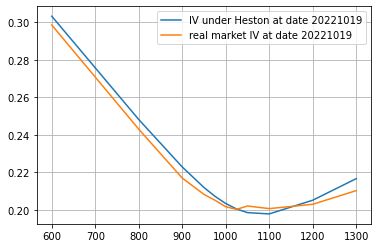

In [6]:
#### date = 20221019
plt.plot(strike_ls, vol_Heston, label='IV under Heston at date {}'.format(date))
plt.plot(strike_ls, IV_df.loc[date,:]/100, label='real market IV at date {}'.format(date))
plt.legend()
plt.grid()
plt.show()

We then try to search the best-fitted parameters by searching different combinations of sigma, vov, rho, mr and theta. And the parameters that has the minimum mean abosulote erro is: sigma = 0.05, vov = 0.45, rho = -0.2, mr = 0.28, theta = 0.06, and the minimum MAE = 0.001952.   
The results is sightly different from the results we find by hand-searching. We will use sigma = 0.05, vov = 0.45, rho = -0.2, mr = 0.28, theta = 0.06 in the following pricing part. 

In [21]:
MAE_list = []    # ['sigma', 'vov', 'rho', 'mr', 'theta', 'MAE'])
for sigma in np.arange(0.04, 0.06, 0.01):
    for vov in np.arange(0.4, 0.6, 0.05):
        for rho in np.arange(-0.2, -0.4, -0.05):
            for mr in np.arange(0.1, 0.3, 0.02):
                for theta in np.arange(0, 0.1, 0.01):
                    model_fitting = pf.HestonFft(sigma=sigma, vov=vov, rho=rho, mr=mr, theta=theta, intr=0.0273)
                    _vol_heston = model_fitting.vol_smile(np.array(strike_ls)/1000 * underlying_price, underlying_price, texp=1)
                    MAE = np.mean(np.abs(_vol_heston - IV_df.loc[date,:]/100))
                    MAE_list.append([sigma, vov, rho, mr, theta, MAE])

In [22]:
MAE_df = pd.DataFrame(MAE_list, columns=['sigma', 'vov', 'rho', 'mr', 'theta', 'MAE'])
min_idx = MAE_df.MAE.idxmin()
MAE_df.loc[min_idx,:]

sigma    0.050000
vov      0.450000
rho     -0.200000
mr       0.280000
theta    0.060000
MAE      0.001952
Name: 2096, dtype: float64

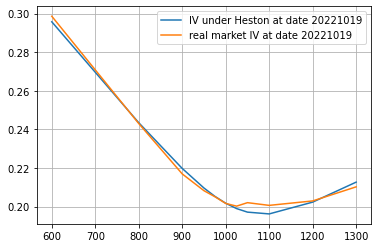

In [23]:
underlying_price = CSI500ETF_close.loc['2022-10-19','close']
model_Heston = pf.HestonFft(sigma = 0.05, vov = 0.45, rho = -0.2, mr = 0.28, theta = 0.06, intr=0.0273)
vol_Heston = model_Heston.vol_smile(np.array(strike_ls)/1000 * underlying_price, underlying_price, texp=1)

#### date = 20221019
plt.plot(strike_ls, vol_Heston, label='IV under Heston at date {}'.format(date))
plt.plot(strike_ls, IV_df.loc[date,:]/100, label='real market IV at date {}'.format(date))
plt.legend()
plt.grid()
plt.show()

## 3. Pricng Results

### 3.1 Product 1: CITIC Snowball product NO.2
1. **Underlying asset**: 000905.SH



2. **Start date**: 2021/08/26


3. **End date**: 2026/08/28

 
4. **closure period**: 3 month


5. **Observation period**:       
    Observe knock in everyday   
    Knock out Observation start date: 2021/11/26     
    Knock out Observation end date: 2023/08/25        
    Observe knock out every month   
    
    
6. **Redemption date**: 2023/08/23 - 2026/08/12


7. **Knock out level**: 100%


8. **Knock in level**: 75%


9. **Annual return**: 15.2%

In [25]:
# BS model
CSI500_close = pd.read_excel('000905_close_price.xlsx',index_col='dates')
spot = CSI500_close.loc['2021-08-26', 'close']
texp = 2
coupon_rate = 0.152
bound = [0.75, 1]
notional = 10000
snowball = Snowball(BSMC, texp, coupon_rate, bound, n_path=30000, notional=notional)
snowball.set_model_param(sigma=0.2225, intr=0.0273)
price = snowball.price(spot)
print(f'Under BS model, the price of snowball product 1 is: {price}')

Under BS model, the price of snowball product 1 is: 9980.968253993102


In [43]:
# Heston model
texp = 2
coupon_rate = 0.152
bound = [0.75, 1]
notional = 10000
snowball = Snowball(HestonMC, texp, coupon_rate, bound, n_path=10000, notional=notional)
snowball.set_model_param(sigma=0.05, vov=0.45, rho=-0.2, mr=0.28, theta=0.06, intr=0.0273)
price = snowball.price(spot, Andersen=True)
print(f'Under Heston model, the price of snowball product 1 is: {price}')

Under Heston model, the price of snowball product 1 is: 10202.224971272099


### Product 2: CITIC Snowball product NO.3

1. **Underlying asset**: CSI Small Cap 500 Index


2. **Start date**: 2021/09/10


3. **End date**: 2026/08/24


4. **closure period**: 3 month


5. **Observation period**:

    + Observation start date: 2021/12/10
   
    + Observation end date: 2023/09/08
    
    + Observe knock in everyday
    
    + Observe knock out every month 
  
  
6. **Maturity date**: 2023/09/07 - 2026/08/17


7. **Knock out level**: 100%


8. **Knock in level**: 75%


9. **Annual return**: 15.7%


In [27]:
# BS model
spot = CSI500_close.loc['2021-9-10', 'close']
texp = 2
coupon_rate = 0.157
bound = [0.75, 1]
notional = 10000
snowball = Snowball(BSMC, texp, coupon_rate, bound, n_path=30000, notional=notional)
snowball.set_model_param(sigma=0.2225, intr=0.0273)
price = snowball.price(spot=spot)
print(f'Under BS model, the price of snowball product 2 is: {price}')

Under BS model, the price of snowball product 2 is: 9999.572203837804


In [28]:
# Heston Model
spot = CSI500_close.loc['2021-9-10', 'close']
texp = 2
coupon_rate = 0.157
bound = [0.75, 1]
notional = 10000
snowball = Snowball(HestonMC, texp, coupon_rate, bound, n_path=10000,notional=notional)
snowball.set_model_param(sigma=0.05, vov=0.45, rho=-0.2, mr=0.28, theta=0.06, intr=0.0273)
price = snowball.price(spot, Andersen=True)
print(f'Under Heston model, the price of snowball product 2 is: {price}')

Under Heston model, the price of snowball product 2 is: 10226.01776042576


### Product 3: CITIC Snowball product NO.7
1. **Underlying asset**: 000905.SH


2. **Start date**: 2021/05/14


3. **End date**: 2026/04/21


4. **closure period**: 3 month


5. **Observation period** 
    Observation start date: 2021/8/13  
    Observation end date: 2023/05/17  
    Observe knock in everyday  
    Observe knock out every month  
  
  
6. **Redemption date**: 2023/05/16 - 2026/04/21


7. **Knock out level**: 103%


8. **Knock in level**: 75%


9. **Annual return**: 15.2%

In [29]:
# BS model
spot = CSI500_close.loc['2021-5-14', 'close']
texp = 2
coupon_rate = 0.152
bound = [0.75, 1.03]
notional = 10000
snowball = Snowball(BSMC, texp, coupon_rate, bound, n_path=30000, notional=notional)
snowball.set_model_param(sigma=0.2225, intr=0.0273)
price = snowball.price(spot=spot)
print(f'Under BS model, the price of snowball product 3 is: {price}')

Under BS model, the price of snowball product 3 is: 9939.986026704333


In [30]:
# Heston model
spot = CSI500_close.loc['2021-5-14', 'close']
texp = 2
coupon_rate = 0.152
bound = [0.75, 1.03]
notional = 10000
snowball = Snowball(HestonMC, texp, coupon_rate, bound, n_path=10000,notional=notional)
snowball.set_model_param(sigma=0.05, vov=0.45, rho=-0.2, mr=0.28, theta=0.06, intr=0.0273)
price = snowball.price(spot, Andersen=True)
print(f'Under Heston model, the price of snowball product 3 is: {price}')

Under Heston model, the price of snowball product 3 is: 10259.336239352562


## 4. Parameter Analysis

We further explored how the parameters of Heston model influence the volatility smile and the price of snowball, the parameters are, namely, sigma, vov, rho, mr, and tehta.  
### 4.1 sigma
The `sigma` in Heston model is the $v_t$ in equation (4), and is the square of $\sigma_t$ in equation (3).   
1. **Sigma and IV**: As shown in the following pictures, when `sigma` changes, the volatility smile calculated under Heston model move up and down in parallel. When `sigma` increases, the IV under Heston will move up, when `sigma` decreases, the IV under Heston will move down.   
2. **Sigma and Snowball price**: As shown in the following table, price will decrease when `sigma` increases. The result is consistent with expectation. Purchasing snowball product has short position in volatility, so when `sigma` increase, the price should be lower.

In [31]:
spot = CSI500_close.loc['2021-5-14', 'close']
texp = 2
coupon_rate = 0.152
bound = [0.75, 1]
notional = 10000

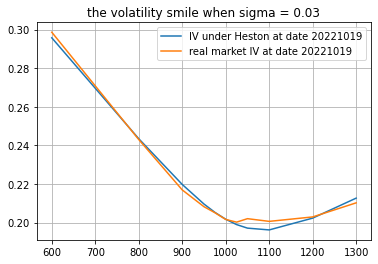

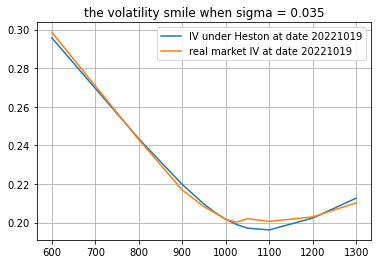

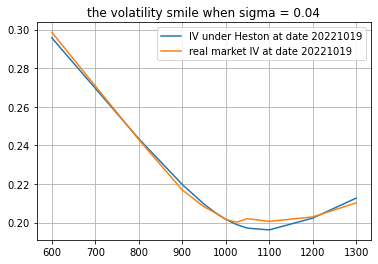

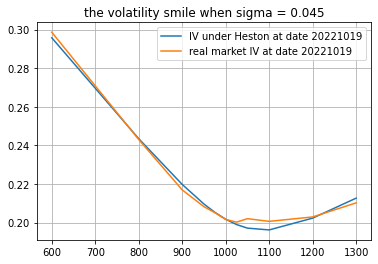

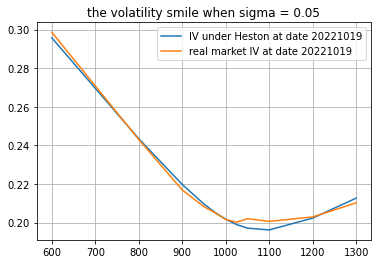

In [32]:
sigma_price_list = []
for sigma in np.linspace(0.03, 0.05, 5):
    model_Heston = pf.HestonFft(sigma=0.05, vov=0.45, rho=-0.2, mr=0.28, theta=0.06, intr=0.0273)
    vol_Heston = model_Heston.vol_smile(np.array(strike_ls)/1000 * underlying_price, underlying_price, texp=1)
    date = 20221019
    plt.plot(strike_ls, vol_Heston, label='IV under Heston at date {}'.format(date))
    plt.plot(strike_ls, IV_df.loc[date,:]/100, label='real market IV at date {}'.format(date))
    plt.title('the volatility smile when sigma = {}'.format(sigma))
    plt.legend()
    plt.grid()
    plt.show()
    
    # pricing part
    snowball = Snowball(HestonMC, texp, coupon_rate, bound, n_path=10000, notional=notional)
    snowball.set_model_param(sigma=sigma, vov=0.45, rho=-0.2, mr=0.28, theta=0.06, intr=0.0273)
    price = snowball.price(spot, Andersen=True)
    sigma_price_list.append([sigma, price])

In [33]:
pd.DataFrame(sigma_price_list, columns=['sigma', 'snowball_price'])

,sigma,snowball_price
0,0.030,10359.454195
1,0.035,10312.214783
2,0.040,10279.986700
3,0.045,10243.115392
4,0.050,10202.224971


### 4.2 vov
The `vov` in Heston model is the  volatility of volatility, is the $\nu$ in equation (4). 
1. **vov and IV**: As shown in the following pictures, when `vov` changes, the convexity of volatility smile calculated under Heston model changes. When `vov` increases, the volatility curve bocomes more convex, when `vov` decrease, the volatility curve becomes flatter.  
    - When vov increases, the ATM IV will drop; when vov decreases, the ATM IV will increase.
    - When vov increases, the IV with low strike will increase; when vov decrease, vise versa.  
2. **vov and Snowball price**: when `vov` increase, the price of snowball increases as well.

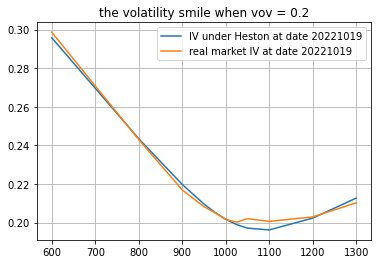

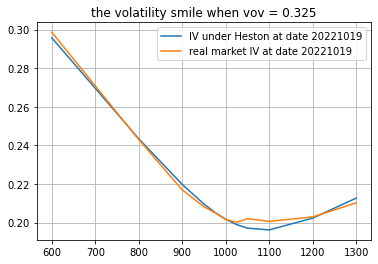

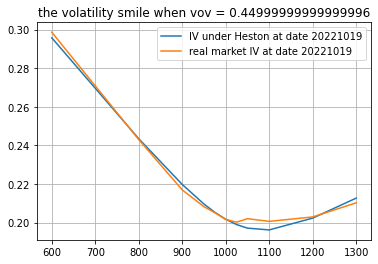

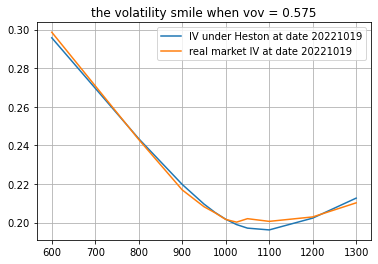

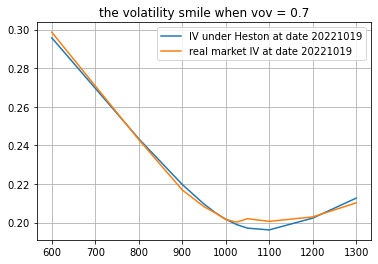

In [34]:
vov_price_list = []
for vov in np.linspace(0.2, 0.7, 5):
    model_Heston = pf.HestonFft(sigma=0.05, vov=0.45, rho=-0.2, mr=0.28, theta=0.06, intr=0.0273)
    vol_Heston = model_Heston.vol_smile(np.array(strike_ls)/1000 * underlying_price, underlying_price, texp=1)
    date = 20221019
    plt.plot(strike_ls, vol_Heston, label='IV under Heston at date {}'.format(date))
    plt.plot(strike_ls, IV_df.loc[date,:]/100, label='real market IV at date {}'.format(date))
    plt.title('the volatility smile when vov = {}'.format(vov))
    plt.legend()
    plt.grid()
    plt.show()
        
    # pricing part
    snowball = Snowball(HestonMC, texp, coupon_rate, bound, n_path=10000, notional=notional)
    snowball.set_model_param(sigma=0.05, vov=vov, rho=-0.2, mr=0.28, theta=0.06, intr=0.0273)
    price = snowball.price(spot, Andersen=True)
    vov_price_list.append([vov, price])

In [35]:
pd.DataFrame(vov_price_list, columns=['vov', 'snowball_price'])

,vov,snowball_price
0,0.200,9986.190704
1,0.325,10084.394582
2,0.450,10202.224971
3,0.575,10273.775741
4,0.700,10331.753326


### 4.3 rho
The `rho` in Heston model is the correlation between two Broniam motions which drive $S_t$ and $v_t$. `rho` is the $\rho$ in equation (5). 
1. **rho and IV**: As shown in the following pictures, when `rho` changes, the skew (or the slope) of volatility smile calculated under Heston model changes. When `rho` decreases to negative, the IV becomes downside skew, low strike has high IV, high strike has low IV, and vise versa. But in this case, the ATM IV is similar in spite of the changes in `rho`. 
2. **rho and Snowball price**: as `rho` decreases, the price of snowball also decreases. When rho decrease, the IV is more skewed, the IV of low strike is higher, the IV of high strike is lower, so the snowball is more likely to knock in and less likely to knock out, so the price of snowball is lower. 

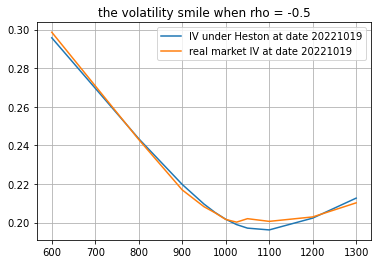

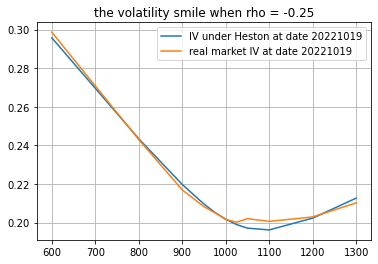

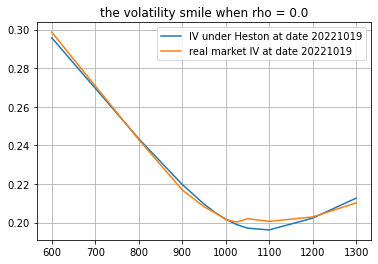

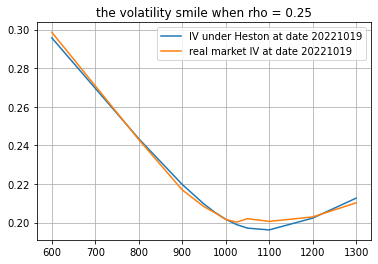

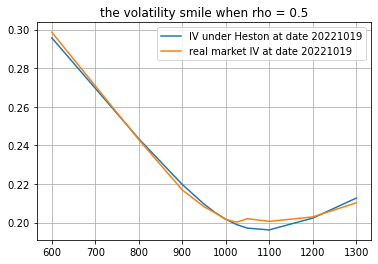

In [36]:
rho_price_list = []
for rho in np.linspace(-0.5, 0.5, 5):
    model_Heston = pf.HestonFft(sigma=0.05, vov=0.45, rho=-0.2, mr=0.28, theta=0.06, intr=0.0273)
    vol_Heston = model_Heston.vol_smile(np.array(strike_ls)/1000 * underlying_price, underlying_price, texp=1)
    date = 20221019
    plt.plot(strike_ls, vol_Heston, label='IV under Heston at date {}'.format(date))
    plt.plot(strike_ls, IV_df.loc[date,:]/100, label='real market IV at date {}'.format(date))
    plt.title('the volatility smile when rho = {}'.format(rho))
    plt.legend()
    plt.grid()
    plt.show()
                
    # pricing part
    snowball = Snowball(HestonMC, texp, coupon_rate, bound, n_path=10000, notional=notional)
    snowball.set_model_param(sigma=0.05, vov=0.45, rho=rho, mr=0.28, theta=0.06, intr=0.0273)
    price = snowball.price(spot, Andersen=True)
    rho_price_list.append([rho, price])

In [37]:
pd.DataFrame(rho_price_list, columns=['rho', 'snowball_price'])

,rho,snowball_price
0,-0.50,10078.825495
1,-0.25,10182.780655
2,0.00,10290.579882
3,0.25,10436.554991
4,0.50,10629.940836


### 4.4 mr
The `mr` in Heston model is the $\kappa$ in equation (4). 
1. **mr and IV**: As shown in the following pictures, when `mr` changes, the convexity of volatility smile calculated under Heston model changes. When `mr` increases, the IV becomes less convex, when `mr` increases, the IV becomes more convex. When `mr` is changing, the IV of low strike is quie similar, which is different to `vov`, when `vov` changes the IV of different strikes all changes significantly.  
2. **mr and Snowball price**: when `mr` increases, the price of snowball will decrease. This is opposite to the effect of `vov`. 

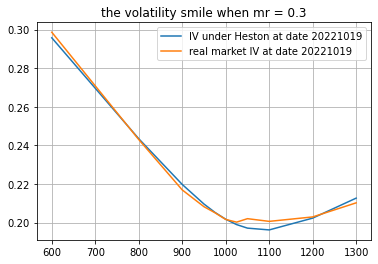

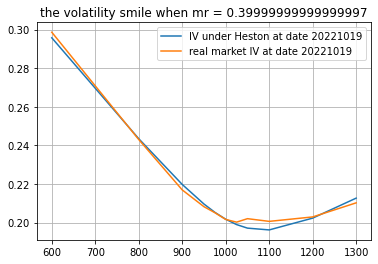

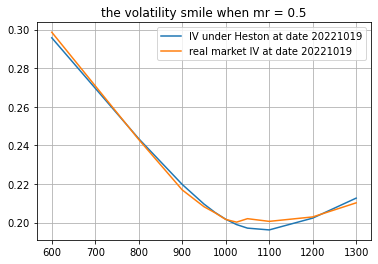

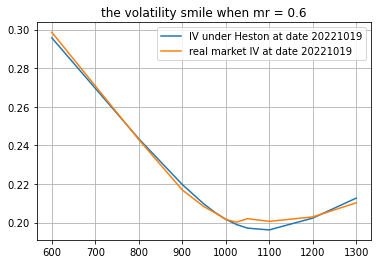

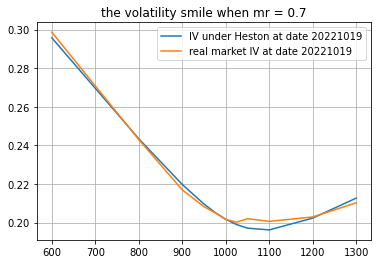

In [38]:
mr_price_list = []
for mr in np.linspace(0.3, 0.7, 5):
    model_Heston = pf.HestonFft(sigma=0.05, vov=0.45, rho=-0.2, mr=0.28, theta=0.06, intr=0.0273)
    vol_Heston = model_Heston.vol_smile(np.array(strike_ls)/1000 * underlying_price, underlying_price, texp=1)
    date = 20221019
    plt.plot(strike_ls, vol_Heston, label='IV under Heston at date {}'.format(date))
    plt.plot(strike_ls, IV_df.loc[date,:]/100, label='real market IV at date {}'.format(date))
    plt.title('the volatility smile when mr = {}'.format(mr))
    plt.legend()
    plt.grid()
    plt.show()
    
    # pricing part
    snowball = Snowball(HestonMC, texp, coupon_rate, bound, n_path=10000, notional=notional)
    snowball.set_model_param(sigma=0.05, vov=0.45, rho=-0.2, mr=mr, theta=0.06, intr=0.0273)
    price = snowball.price(spot, Andersen=True)
    mr_price_list.append([mr, price])

In [39]:
pd.DataFrame(mr_price_list, columns=['mr', 'snowball_price'])

,mr,snowball_price
0,0.3,10195.367966
1,0.4,10159.481172
2,0.5,10115.243291
3,0.6,10089.771097
4,0.7,10068.363883


### 4.5 theta
The `theta` is the $\theta$ in equation (4). 
1. **theta and IV**: As shown in the following pictures, when `theta` changes, both the convexity and the location of volatility smile calculated under Heston model changes. When `theta` increases, the IV will move upwards for all strikes, and the curve becomes flatter. 
2. **theta and Snowball price**: when `theta` increases, the price of snowball decreases because the IV moves upwards and the curve becomes flatter. The result is consistent with the reuslts of change `vov` and `sigma`. 

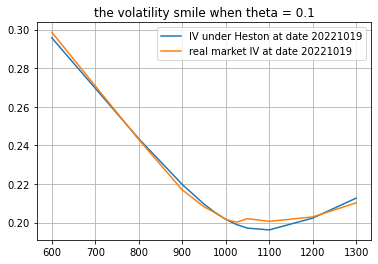

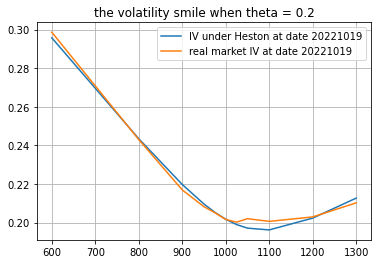

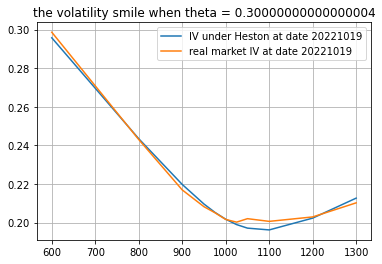

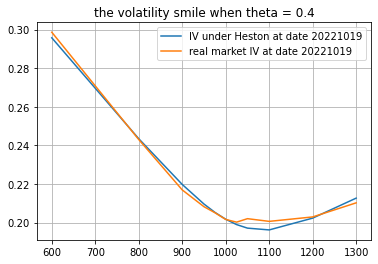

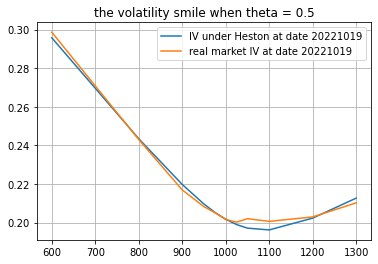

In [40]:
theta_price_list = []
for theta in np.linspace(0.1, 0.5, 5):
    model_Heston = pf.HestonFft(sigma=0.05, vov=0.45, rho=-0.2, mr=0.28, theta=0.06, intr=0.0273)
    vol_Heston = model_Heston.vol_smile(np.array(strike_ls)/1000 * underlying_price, underlying_price, texp=1)
    date = 20221019
    plt.plot(strike_ls, vol_Heston, label='IV under Heston at date {}'.format(date))
    plt.plot(strike_ls, IV_df.loc[date,:]/100, label='real market IV at date {}'.format(date))
    plt.title('the volatility smile when theta = {}'.format(theta))
    plt.legend()
    plt.grid()
    plt.show()
    
    # pricing part
    snowball = Snowball(HestonMC, texp, coupon_rate, bound, n_path=10000, notional=notional)
    snowball.set_model_param(sigma=0.05, vov=0.45, rho=-0.2, mr=0.28, theta=theta, intr=0.0273)
    price = snowball.price(spot, Andersen=True)
    theta_price_list.append([theta, price])

In [41]:
pd.DataFrame(theta_price_list, columns=['theta', 'snowball_price'])

,theta,snowball_price
0,0.1,10092.892251
1,0.2,9962.436262
2,0.3,9877.042145
3,0.4,9823.966701
4,0.5,9779.263911


## 5. Further Discussion
We find that the pricing results are actually not good, and we think the possible reason is: 
- The IV of the day we choose is does not reflect the IV of the date when the snowball products is issued. We noticed the IV has experienced great changes since CSI500 ETF option has listed. Compared with the other group, we choose different dates to modeling IV and use different parameters, which might be the cause of the difference of Heston model. For BS model, we think our results are similar.   
    We randomly choose 5 dates, and plot the IV of CSI500 ETF option for 5 different dates. As shown in the following figure, the implied volatility of different dates has different pattern, it's hard to tell which date is more suitable to pricing for the snowball products provided by PingAn Bank at Year 2021. 

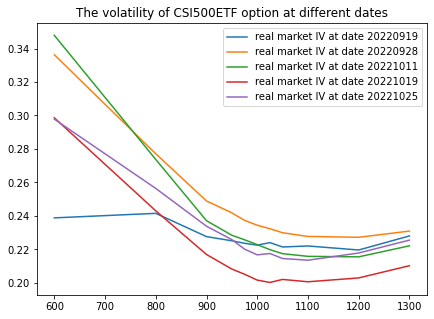

In [52]:
plt.figure(figsize=(7,5))
date1 = 20220919
plt.plot(strike_ls, IV_df.loc[date1,:]/100, label='real market IV at date {}'.format(date1))
date2 = 20220928
plt.plot(strike_ls, IV_df.loc[date2,:]/100, label='real market IV at date {}'.format(date2))
date3 = 20221011
plt.plot(strike_ls, IV_df.loc[date3,:]/100, label='real market IV at date {}'.format(date3))
date4 = 20221019
plt.plot(strike_ls, IV_df.loc[date4,:]/100, label='real market IV at date {}'.format(date4))
date5 = 20221025
plt.plot(strike_ls, IV_df.loc[date5,:]/100, label='real market IV at date {}'.format(date5))
plt.legend()
plt.title('The volatility of CSI500ETF option at different dates')
plt.show()

To verity our assumption, we then chooose another date(2022-09-), and fit the implied volatility of 2022-10-11 by hand. The change the parameter by hand and find the parameters that fit the IV is: sigma=0.066, vov=0.46, rho=-0.35, mr=0.05, theta=0.3.   
The we apply the parameter to pricing for the first product, and the result is 9993.75.

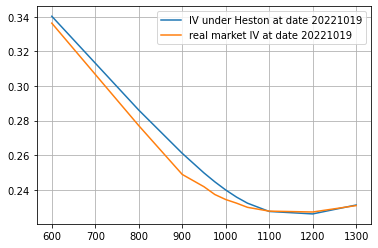

In [147]:
CSI500ETF_close = pd.read_excel('500ETF_close_price.xlsx',index_col=0)
underlying_price = CSI500ETF_close.loc['2022-09-28','close']
model_Heston = pf.HestonFft(sigma=0.066, vov=0.46, rho=-0.35, mr=0.05, theta=0.3, intr=0.0273)
vol_Heston = model_Heston.vol_smile(np.array(strike_ls)/1000 * underlying_price, underlying_price, texp=1)

plt.plot(strike_ls, vol_Heston, label='IV under Heston at date {}'.format(date))
plt.plot(strike_ls, IV_df.loc[20220928,:]/100, label='real market IV at date {}'.format(date))
plt.legend()
plt.grid()
plt.show()

In [148]:
# Heston model
texp = 2
coupon_rate = 0.152
bound = [0.75, 1]
notional = 10000
snowball = Snowball(HestonMC, texp, coupon_rate, bound, n_path=10000, notional=notional)
snowball.set_model_param(sigma=0.066, vov=0.46, rho=-0.35, mr=0.05, theta=0.3, intr=0.0273)
price = snowball.price(spot, Andersen=True)
print(f'Under Heston model, the price of snowball product 1 is: {price}')

Under Heston model, the price of snowball product 1 is: 9993.749506982744


This implies that find the implied volatility can influence the the pricing result greatly in a stochastic volatility model. The IV used should be carefully selected. Besides, the the pricing result is also very sensitive to the parameters (sigma, vov, rho, mr and theta), and the parmaters should be carefully selected as well. 

## Reference 
[1] Prof. Choi. PHBS 2022Fall module 1 ASP course slides  
[2] Industrial Security.(2021) .*OTC Options Series 5: How to Price a Snowball Option*. https://max.book118.com/html/2021/0629/6034054242003204.shtm  
[3] Andersen L (2008) Simple and efficient simulation of the Heston stochastic volatility model. Journal of Computational Finance 11:1–42. https://doi.org/10.21314/JCF.2008.189  
